In [128]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [183]:
import math
from inspect import isfunction
from functools import partial
from tqdm.auto import tqdm
from einops import rearrange, repeat

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, einsum
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib

from sklearn.datasets import make_moons

In [130]:
FIG_SIZE = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
matplotlib.rcParams['figure.figsize'] = (FIG_SIZE, FIG_SIZE)

# Datasets

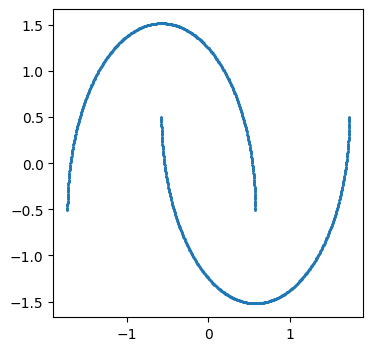

In [176]:
N_SAMPLES = 1000
BATCH_SIZE = 128

X, _ = make_moons(n_samples=N_SAMPLES)
X = (X - X.mean(axis=0)) / X.std(axis=0) # center and normalize
X = torch.tensor(X, dtype=torch.float32)
X = X.to(device)

dataloader = DataLoader(X, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

plt.scatter(X.cpu()[:, 0], X.cpu()[:, 1], s=1)

# $\beta$ scheduler

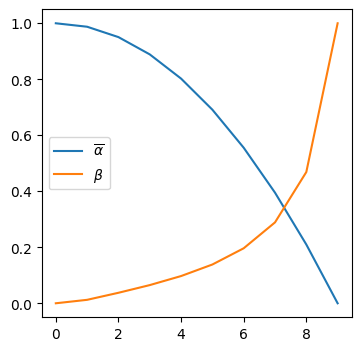

In [177]:
T = 10

# linear scheduling
# alpha_bar = torch.linspace(1, 0, T).to(device)

# cosine scheduling
# s = 1e-2
# f = lambda t_T: torch.cos((t_T + s)/(1 + s) * torch.pi/2)**2
# alpha_bar = f(torch.linspace(0, 1, T).to(device)) / f(torch.zeros(1))

# linear re-parametrization
alpha_bar = torch.linspace(1, 0, T).to(device)
alpha_bar = 1 - (1 - alpha_bar)**2


sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)

beta_0 = torch.zeros(1).to(device)
beta = 1 - (alpha_bar[1:] / alpha_bar[:-1])
beta = torch.cat([beta_0, beta])

assert len(alpha_bar) == len(beta) == T, "alpha_bar and beta should have the same length"
assert torch.allclose((1 - beta).cumprod(0), alpha_bar), "alpha_bar and beta are not consistent"

plt.plot(alpha_bar.cpu(), label="$\overline{\\alpha}$")
plt.plot(beta.cpu(), label="$\\beta$")
plt.legend();


# Forward

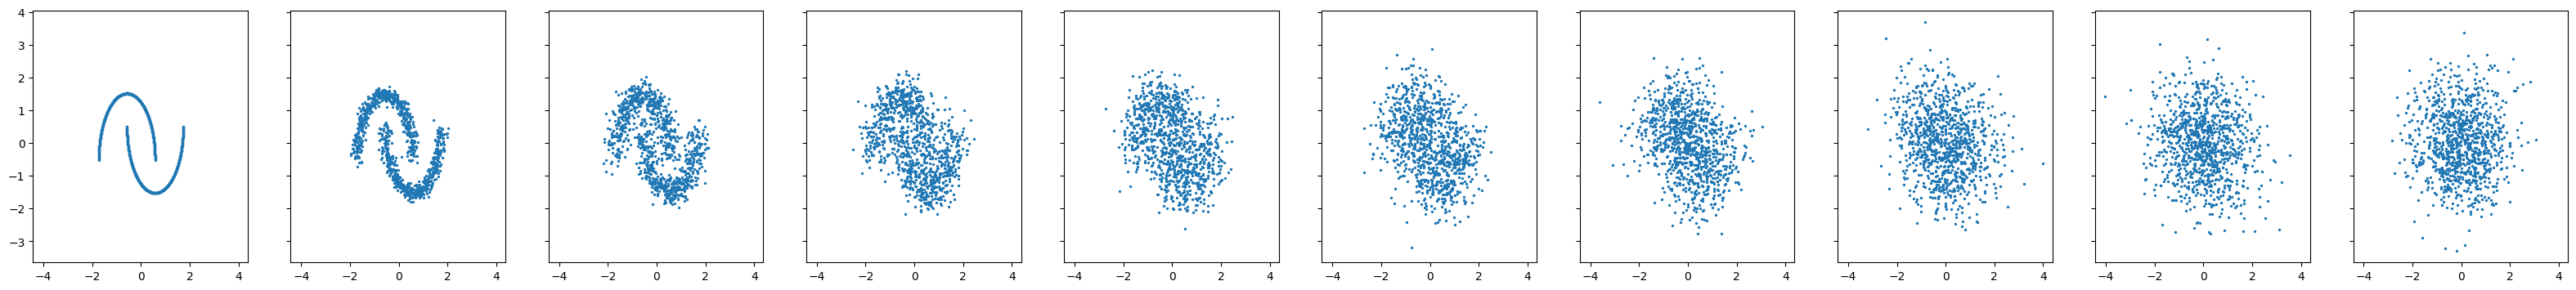

In [178]:
def forward(xs_0, time_steps):
    assert len(time_steps.shape) == 2, "time_steps should be a 2D tensor"
    assert len(xs_0.shape) == 2, "xs_0 should be a 2D tensor"
    n0, d = xs_0.shape
    n1, k = time_steps.shape
    assert n0 == n1, "xs_0 and time_steps should have the same batch size"

    xs_0 = repeat(xs_0, "n d -> n k d", k=k)
    time_steps = repeat(time_steps, "n k -> n k d", d=d)

    noise = torch.randn_like(xs_0)
    sqrt_alpha_bar_t = sqrt_alpha_bar[time_steps]
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[time_steps]
    x_t = sqrt_alpha_bar_t * xs_0 + sqrt_one_minus_alpha_bar_t * noise
    return x_t

time_steps = repeat(torch.arange(T), "k -> n k", n=N_SAMPLES).to(device)
xs_t = forward(X, time_steps)
_, axes = plt.subplots(1, T, figsize=(FIG_SIZE * T, FIG_SIZE), sharex=True, sharey=True)
for t in range(T):
    axes[t].scatter(xs_t[:, t, 0], xs_t[:, t, 1], s=2)

# Network

In [237]:
# inspired from https://amaarora.github.io/2020/09/13/unet.html and https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=LQnlc27k7Aiw

class Block(nn.Module):
    def __init__(self, in_ch, out_ch) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

class Encoder(nn.Module):
    def __init__(self, chs) -> None:
        super().__init__()
        self.blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs) - 1)])
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        features = []
        for block in self.blocks:
            x = block(x)
            features.append(x)
            x = self.pool(x)
        return features[-1], features

class Decoder(nn.Module):
    def __init__(self, chs) -> None:
        super().__init__()
        self.blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs) - 1)])
        self.up_convs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], kernel_size=2, stride=2) for i in range(len(chs) - 1)])

    def forward(self, x, enc_features):
        for block, up_conv, enc_feature in zip(self.blocks, self.up_convs, enc_features):
            x = up_conv(x)
            x = torch.cat([enc_feature, x], dim=1)
            x = block(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_chs=(1,64,128,256,512,1024), out_chs=(1024, 512, 128, 64, 1)) -> None:
        super().__init__()
        self.encoder = Encoder(in_chs)
        self.decoder = Decoder(out_chs)
        self.head = nn.Conv2d(out_chs[-2], out_chs[-1], kernel_size=1)

    def forward(self, x):
        x, enc_features = self.encoder(x)
        x = self.decoder(x, enc_features[:-1][::-1])
        x = self.head(x)
        return x

class Model(nn.Module):
    def __init__(self, input_dim) -> None:
        super().__init__()
        # if sum(input_dim) < 
        self.unet = UNet((), out_chs)

    def forward(self, x):
        x = self.unet(x)
        return x

# encoder = Encoder((1,64,128,256,512,1024))
# # input image
# x, ftrs = encoder(x)
# for ftr in ftrs: print(ftr.shape)
# print(x.shape)

# decoder = Decoder((1,64,128,256,512,1024)[::-1])
# x = torch.randn(1, 1024, 28, 28)
# decoder(x, ftrs[:-1][::-1]).shape

x_prime = torch.randn(10, 2, 1, 2)
model = UNet(in_chs=(2,64), out_chs=(64,1)).to(device)
model(x_prime).shape

RuntimeError: Given input size: (64x1x2). Calculated output size: (64x0x1). Output size is too small